# FERS Tutorial Notebook
This notebook presents a tutorial to get FERS noobs up and running quickly.

It is assumed that you are running FERS locally, i.e. `fers` can be run from anywhere in your terminal. Feel free to use the server.sh file if you have a remote setup.

First, import some important modules.

In [1]:
import fers as fers

import os
import sys
import matplotlib.pyplot as plt
import numpy as np

from numpy import matlib as mb
from scipy.signal import spectrogram, decimate
from scipy import interpolate
from PIL import Image

Next, set some constants and default file names.

In [2]:
FERS_INPUT_FILENAME = "up_chirp.h5"
FERS_XML_FILENAME = "sim.fersxml"
FERS_OUTPUT_FILENAME = "receiver.h5"

BOLTZMANN = 1.38064852e-23
c = 299792458

Define a couple of convenience functions.

In [3]:
def lin2db(lin):
    '''
    Conversion from linear to decibels.
    '''
    return 10*np.log10(lin)

def achirp(period, sample_rate, bandwidth, init_freq=0, tau=0, phi=0):
    '''
    Generate an analytic baseband chirp.
    '''
    ns_chirp = int(np.ceil(period*sample_rate))
    t_chirp = np.linspace(-period/2, period/2, ns_chirp, endpoint=False)
    return np.exp(1.j*(np.pi*bandwidth/(2*max(t_chirp))*pow((t_chirp - tau), 2) + 2*np.pi*init_freq*(t_chirp - tau) + phi)).astype('complex64')

def next_pow_two(number):
    '''
    Returns the next power of two.
    '''
    return int(pow(2, np.ceil(np.log2(number))))

Define the Target class.

In [4]:
class Target:
    def __init__(self, name, x, y, z, t, rcs):
        self.name = name
        self.x = x
        self.y = y
        self.z = z
        self.t = t
        self.rcs = rcs

Now, set parameters about the radar platform.

In [5]:
velocity = 30
height = 1
n_seconds = 1

distance = n_seconds * velocity

# TODO: add irregular motion to data
# x = np.zeros(10)
x = np.random.randint(-10,10, size=10)
y = np.linspace(0, distance, num=10)
z = np.ones(10) * height
t = np.linspace(0, n_seconds, num=10)

'''
waypoints = np.array([
    [0, 150, 150, 0],             # x: swath
    [0, distance/2, distance/2, distance],             # y: cross range
    [height, height, height, height],   # z: altitude
    [0, n_seconds/2, n_seconds/2, n_seconds]      # t: time
])'''

waypoints = np.array([
    x,
    y,
    z,
    t
])

Add as many targets as you please.

In [6]:
targets = []
targets.append(Target(name='A', x=[200], y=[15], z=[0.1], t=[0], rcs=50))
targets.append(Target(name='B', x=[300], y=[15], z=[0.1], t=[0], rcs=50))
targets.append(Target(name='C', x=[400], y=[15], z=[0.1], t=[0], rcs=50))

Radar parameters are set next.

In [7]:
fc = 2.45e9
wavelength = c/fc
ramp_bandwidth = 100e6 #50e6
adc_rate = 125e6    #100e6
decimation_factor = 40  #100
os_factor = 1   #1
adc_bits = 14   #14
rf_sim_rate = adc_rate * os_factor
tx_power = 10   # [W]
noise_temp = 290
noise_density = BOLTZMANN * noise_temp # [W/Hz]

print('Noise density:', np.round(lin2db(noise_density) + 30, 2), '[dBm/Hz]')

prf = 1250 # Hz - was 1000 Hz
ramp_period = 1/prf
bb_sample_rate = adc_rate/decimation_factor

n_pulses = int(prf*n_seconds) # number of PRIs
ns_pulse = int(ramp_period*bb_sample_rate)
ns_fft = next_pow_two(ns_pulse)

# time axes
t_rf  = np.linspace(0, ramp_period, int(ramp_period*rf_sim_rate), endpoint=False)
t_adc = np.linspace(0, ramp_period, int(ramp_period), endpoint=False)
t_bb = np.linspace(0, ramp_period, int(ramp_period*bb_sample_rate), endpoint=False)

# range axes
f_fft = np.linspace(-bb_sample_rate/2, bb_sample_rate/2, ns_fft, endpoint=False)
r_fft = ramp_period/ramp_bandwidth * c/2 * f_fft

if (rf_sim_rate < ramp_bandwidth):
    print("Simulation sample rate insufficient, increase the over-sampling factor.")
    exit()

Noise density: -173.98 [dBm/Hz]


Add cycles delay to TX signal

In [8]:
cycles_offset = 100    # number of clock cycles to offset tx chirp by

ns_off_rf = int(np.ceil(os_factor * cycles_offset))

tau_off = cycles_offset / adc_rate

Generate and plot the TX waveform.

/tmp/ipykernel_43949/2029907098.py:5: RuntimeWarning: divide by zero encountered in log10
  return 10*np.log10(lin)


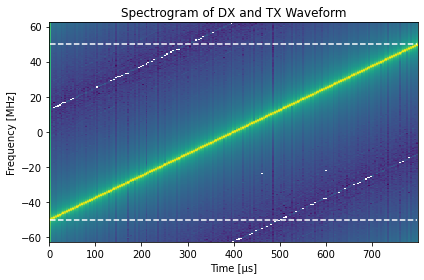

In [9]:
tx_chirp = achirp(
    period = ramp_period,
    sample_rate = rf_sim_rate,
    bandwidth = ramp_bandwidth,
    tau = tau_off
    )

dx_chirp = achirp(
    period = ramp_period,
    sample_rate = rf_sim_rate,
    bandwidth = ramp_bandwidth,
    tau = 0
    )

tx_chirp[0:ns_off_rf] = 0   # force beginning of chirp to ground

chirp_plot = dx_chirp + tx_chirp

f, t, spect = spectrogram(
    chirp_plot, # tx_chirp
    fs=rf_sim_rate, 
    nperseg=512, 
    nfft=512, 
    noverlap=0, 
    mode='magnitude', 
    window='blackman', 
    return_onesided=False, 
    detrend=False
)

spect = 2*lin2db(np.abs(spect))
spect -= spect.max()

spect = np.fft.fftshift(spect, axes=0)
t *= 1e6
f = np.fft.fftshift(f)/1e6

plt.figure()
plt.hlines(ramp_bandwidth/2e6, t[0], t[-1], linestyles='--', colors='white')
plt.hlines(-ramp_bandwidth/2e6, t[0], t[-1], linestyles='--', colors='white')
plt.pcolormesh(t, f, spect)
plt.title('Spectrogram of DX and TX Waveform')
plt.xlabel('Time [µs]')
plt.ylabel('Frequency [MHz]')
plt.tight_layout()
plt.savefig('dx_tx_spectrum', dpi=300)


Set the spacing between transmit and receive antennas.

In [10]:
antenna_spacing = [0, 0.5, 0]
iso_rx_ft = lin2db(tx_power * pow(wavelength/(4*np.pi*np.sqrt(antenna_spacing[0]**2 + antenna_spacing[1]**2 + antenna_spacing[2]**2)), 2)) + 30
print('Feed-through at isotropic RX antenna:', np.round(iso_rx_ft, 2), '[dBm]')

Feed-through at isotropic RX antenna: 5.79 [dBm]


Generate the FERS XML file and run the simulation.

In [11]:
output_dir = os.path.abspath(os.getcwd())

fers.write_hdf5(tx_chirp, os.path.join(output_dir, FERS_INPUT_FILENAME))

fers_xml = fers.FersXMLGenerator(os.path.join(output_dir, FERS_XML_FILENAME))

fers_xml.add_parameters(
    t_start=1//prf, #0,
    t_end=n_seconds,
    sim_rate=rf_sim_rate,
    bits=adc_bits
    )

fers_xml.add_pulse(
    name='up_chirp',
    pulse_file=FERS_INPUT_FILENAME,
    power_watts=tx_power,
    centre_freq=fc
    )

fers_xml.add_clock(name='clock', frequency=adc_rate, synconpulse='false')

fers_xml.add_antenna(name='tx_rx_antenna', pattern='isotropic')
# fers.add_antenna(name='tx_rx_antenna', pattern='parabolic', d=0.1)
# fers.add_antenna(name='tx_rx_antenna', pattern='sinc', a=pow(10, ANTENNA_GAIN/10), b=2, g=5, is_plot=True)

fers_xml.add_pseudo_monostatic_radar(
    spacing=antenna_spacing,
    waypoints=waypoints,
    antenna='tx_rx_antenna',
    timing='clock',
    prf=prf,
    pulse='up_chirp',
    window_length=ramp_period,
    noise_temp=noise_temp,
    nodirect='true'
)

for target in targets:            
    fers_xml.add_target(
        name = target.name,
        x = target.x,
        y = target.y,
        z = target.z,
        t = target.t,
        rcs = target.rcs
    )
    
fers_xml.write_xml()
fers_xml.run()
del fers_xml

rx_matrix = fers.read_hdf5(FERS_OUTPUT_FILENAME)

/------------------------------------------------\
| FERS - The Flexible Extensible Radar Simulator |
| Version 0.28                                   |
\------------------------------------------------/

[VERBOSE] Loading XML Script File.
[CRITICAL] Propagation speed (c) set to custom value: 299792458.00000
[VV] System sample rate set to custom value: 125000000.00000
[VERBOSE] Using random seed from clock(): 1664459539
[VERBOSE] Quantizing results to 14 bits
[VV] Oversampling enabled with ratio 1
[VV] Generating Pulse up_chirp of type 'file'
[VV] Loading antenna 'tx_rx_antenna' of type 'isotropic'
[VV] Loading timing source 'clock'
[VV] Loading Transmitter: 0
[VV] Loading Receiver: 'receiver' 0
[VV] Ignoring direct signals for receiver 'receiver'
[INFO] Using threaded simulation with 8 threads.
[VERBOSE] Created simulator thread for transmitter 'transmitter' and receiver 'receiver' 1250
[VV] 3750 responses added to receiver 'receiver'
[VV] Created render thread for receiver 'receiver'

Remove receiver.h5 from memory

In [12]:
# delete file
sys = os.system('rm -r ' + FERS_OUTPUT_FILENAME)

Perform RF dechirp by mixing RX and DX and filtering result.
Analytic representation eliminates need to filter.

In [13]:
# dx_chirp is a row vector -> repeat over several rows
# now rx_matrix and dx_matrix both have pulses as rows (axis = 1)
# dx_matrix = mb.repmat(tx_chirp, n_pulses, 1)
dx_matrix = mb.repmat(
    dx_chirp,
    prf*os_factor,
    1
)

l = rx_matrix.shape[0]
if (l % decimation_factor) == 1:
    rx_matrix = rx_matrix[:l-1,:]

bb_matrix = np.multiply(dx_matrix, np.conjugate(rx_matrix))
del rx_matrix, dx_matrix

Decimate the data to the final sample rate.

In [14]:
# decimate to ADC rate
bb_matrix = decimate(bb_matrix, os_factor, axis=1, zero_phase=True)
# decimate to final sample rate
bb_matrix = decimate(bb_matrix, decimation_factor, ftype='fir', axis=1)

Transpose the data matrix for pulses down each column.

In [15]:
# beat matrix of data
bb_matrix = np.transpose(bb_matrix)

Plot the time domain beat signal.

/home/tlotliso/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 0, 'Time (us)')

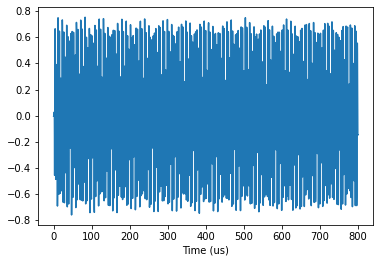

In [16]:
plt.figure()
plt.plot(t_bb*1e6, bb_matrix[:, 0]/np.amax(bb_matrix))
plt.xlabel('Time (us)')

Apply a window of your choice to the time domain beat signal.

In [17]:
window_matrix = np.blackman(ns_pulse)

window_matrix = np.transpose(
    np.tile(window_matrix, (n_pulses, 1)))
    
bb_matrix = np.multiply(bb_matrix, window_matrix)

Take FFT of beat signal.

In [18]:
bb_matrix = np.fft.fftshift(np.fft.fft(
    bb_matrix, ns_fft, axis=0), axes=0)

Plot a range profile of the pulse in the middle of the experiment.

Text(0.5, 1.0, 'Range Profile of Middle Pulse')

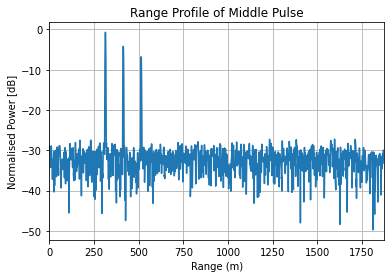

In [19]:
plt.figure()
plt.plot(r_fft, lin2db(abs(bb_matrix[:, n_pulses//2])/np.amax(bb_matrix)))
plt.xlim(0, r_fft[-1])
plt.grid()
plt.xlabel('Range (m)')
plt.ylabel('Normalised Power [dB]')
plt.title('Range Profile of Middle Pulse')

Generate a range-time-intensity plot of the data matrix.

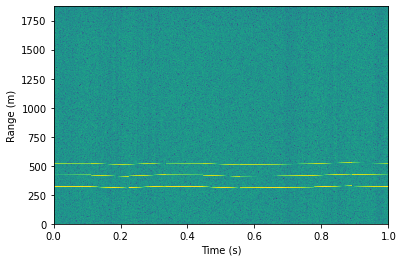

In [20]:
image_axes = [0, n_seconds, r_fft[-1], r_fft[0]]

fig, ax = plt.subplots(nrows=1, ncols=1)
im = ax.imshow(
    lin2db(abs(bb_matrix)),
    aspect='auto',
    # vmax=vmax,
    # vmin=vmin,
    interpolation='none',
    # cmap=cmap,
    extent=image_axes,
)
ax.set_ylim(0, r_fft[-1])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Range (m)')
title = 'rti_' + str(height) + 'm.png'
fig.savefig(title, dpi=300)

Generate g2 files required

In [21]:
# create output directory for processed data
if not os.path.exists(os.path.join(os.getcwd(), 'out/')):
    os.mkdir('out')

# create g2 files required
title = str(height) + 'm_' + str(velocity) + 'ms'
g2_input = os.path.join(os.getcwd(), 'out', title + '.rng')
g2_cmd = os.path.join(os.getcwd(), 'out', title + '.cmd')
g2_log = os.path.join(os.getcwd(), 'out', title + '.log')
g2_out = os.path.join(os.getcwd(), 'out', title + '.azi')

# Save data to file
bb_matrix = np.nan_to_num(bb_matrix)
bb_matrix = np.dstack((bb_matrix, np.zeros_like(bb_matrix)))
bb_matrix.astype('complex64').tofile(g2_input)

SAR radar parameters

In [22]:
from random import sample

chirp_rate = ramp_bandwidth / ramp_period

range_scaling = (c/2) / chirp_rate

fft_bin_spacing = bb_sample_rate / ns_fft

range_bin_spacing = fft_bin_spacing * range_scaling

# pulsed radar equivalent adc rate
g2_adc = c / (2*range_bin_spacing)

min_range_bin = 0

max_range_bin = int(np.floor(r_fft[-1] / range_bin_spacing))

n_range_bins = max_range_bin - min_range_bin

n_chunks = int(prf * n_seconds)

spectral_resolution = bb_sample_rate / n_chunks
range_resolution = range_scaling * np.hypot(spectral_resolution, fft_bin_spacing)

SAR image formation

In [23]:
# To make use of the G2 program
synthetic_aperture = n_seconds * velocity
# Pixel scaling for SAR image
scaled_width = int(n_range_bins / r_fft[-1] * synthetic_aperture)
scaled_height = int(n_range_bins)

Execute g2 commands

In [24]:
with open(g2_cmd, 'w') as f_id:
        f_id.write('miloSAR azimuth compression command file (azcom)\n')
        f_id.write('$ProgramVersion (jmh)         => 1.1\n\n')
        f_id.write('$ScreenUpdateRate             => ' + str(1) + '\n')
        f_id.write('$LogFileName                  => ' + str(g2_log) + '\n')
        f_id.write('$InputStartSampleDelay        => ' + str(0) + '\n')
        f_id.write('$CarrierFreq [Hz]             => ' + str(fc) + '\n')
        f_id.write('$InputPRF [Hz]                => ' + str(prf) + '\n')
        f_id.write('$NomGroundSpeed [m/s]         => ' + str(velocity) + '\n')
        f_id.write('$InputFileAzPts               => ' + str(n_chunks) + '\n')
        f_id.write('$StartProcessAzPt             => ' + str(0) + '\n') #change
        f_id.write('$AzPtsToProcess               => ' + str(n_chunks) + '\n')
        f_id.write('$InputFileRngBins             => ' + str(n_range_bins) + '\n')
        f_id.write('$StartProcessRngBin           => ' + str(0) + '\n') #change
        f_id.write('$RngBinsToProcess             => ' + str(n_range_bins) + '\n')
        f_id.write('$InputDCOffsetI               => ' + str(0.0) + '\n')
        f_id.write('$InputDCOffsetQ               => ' + str(0.0) + '\n')
        f_id.write('$InvFFTSizeReduc [pow of 2]   => ' + str(1) + '\n')
        f_id.write('$InputFileName                => ' + str(g2_input) + '\n')
        f_id.write('$OutputFileName               => ' + str(g2_out) + '\n')
        f_id.write('$AppendExistOutFileFlg [Y/N]  => ' + str('N') + '\n')
        f_id.write('$RngFocSegments               => ' + str(-1) + '\n')
        f_id.write('$RefFuncSign [+-1]            => ' + str(1) + '\n') #change
        f_id.write('$A2DFreq [Hz]                 => ' + str(g2_adc) + '\n')
        f_id.write('$NomAzRes [m]                 => ' + str(range_resolution/4) + '\n')       #hacked
        f_id.write('$WinConstTime [0.0-1.0]       => ' + str(0.08) + '\n')
        f_id.write('$NumLooks                     => ' + str(1) + '\n')
        f_id.write('$LookOverlapFrac [0.0-1.0]    => ' + str(0.0) + '\n')
        f_id.write('$WinConstFreq [0.0-1.0]       => ' + str(0.08) + '\n')
        f_id.write('$RngCurvInterpSize            => ' + str(64) + '\n')
        f_id.write('$RngCurvBatchSize             => ' + str(256) + '\n') #play with this
        f_id.write('$PostSumRatio                 => ' + str(1) + '\n')
        f_id.write('$DetectMethod                 => ' + str(0) + '\n')
        f_id.write('$InputDataType                => ' + str(3) + '\n')
        f_id.write('$OutputDataType               => ' + str(3) + '\n')
        f_id.write('$Scale                        => ' + str(1) + '\n')
        f_id.write('$ReportMax [1/0]              => ' + str(1) + '\n')

azcom_executable = os.path.join(os.getcwd(), 'g2', 'azcom')
os.system(azcom_executable + ' ' + str(g2_cmd))


-----------
Prog: AZCOM (Ver. 1.1)
Code: J.M. Horrell (Copyright UCT 1994-1999)

Focus rng / output rng bin     : 1871.8702 m / 204634 m / 248n     : 451.9569 m / 494utput rng bin     : 677.0205 m / 740ocus rng / output rng bin     : 902.0841 m / 98619.8285 m / 1224put rng bin     : 1552.5727 m / 1697m / 1854
Az Compression Done!


0

Generate and save SAR image

/tmp/ipykernel_43949/4023616498.py:11: RuntimeWarning: divide by zero encountered in log10
  image = 20*np.log10(abs(image))


SAR image saved.


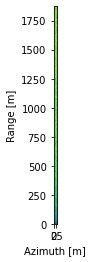

In [25]:
bin_matrix = np.fromfile(g2_out, dtype='complex64')
bin_matrix = np.flipud(bin_matrix.reshape(n_range_bins, n_chunks))
bin_matrix = np.nan_to_num(bin_matrix)

bin_matrix = np.dstack((bin_matrix,))

# Noncoherent averaging of data
image = pow(np.mean(abs(bin_matrix), axis=2), 2)
image.astype('complex64').tofile(os.path.join('out', 'image.bin'))

image = 20*np.log10(abs(image))
image_mean = np.mean(image, axis=1)

# dynamic range
a_min = np.nanmin(image_mean[image_mean != -np.inf])
a_max = np.amax(image)
image = np.clip(image, a_min=a_min, a_max=a_max)
image = (image-a_min)/(a_max-a_min) # image averaging

fig, ax = plt.subplots(nrows=1, ncols=1)
ax.set_xlabel('Azimuth [m]')
ax.set_ylabel('Range [m]')
im = ax.imshow(
    image,
    aspect='equal',
    extent=[0, synthetic_aperture, 0, r_fft[-1]],
    origin='upper'
)

# fig.colorbar(im, ax=ax, orientation='vertical')

file_name = title + '.sar.noco'
image_path = os.path.join('out', file_name)
plt.imsave(image_path, image, cmap='gray', origin='upper', format='png')

sar_image = Image.open(image_path)
sar_image.load()
sar_image = sar_image.resize((scaled_width, scaled_height), resample=Image.LANCZOS)
sar_image.save(os.path.splitext(image_path)[
            0] + os.path.splitext(image_path)[1], format='png')

print("SAR image saved.")

### Motion Compensation by Tlotliso Mapana

Plot signal phase for reference

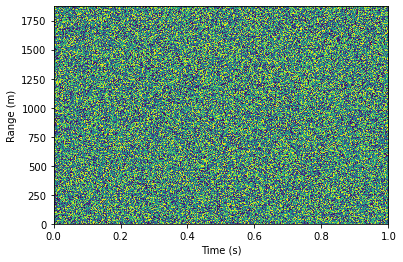

In [26]:
image_axes = [0, n_seconds, r_fft[-1], r_fft[0]]

fig, ax = plt.subplots(nrows=1, ncols=1)
im = ax.imshow(
    np.angle(bb_matrix[:,:,0]),
    aspect='auto',
    interpolation='none',
    # cmap=cmap
    extent=image_axes,
)
ax.set_ylim(0, r_fft[-1])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Range (m)')
title = 'rtp_' + str(height) + 'm.png'
fig.savefig(title, dpi=300)

Determine nominal range by using a linear fit

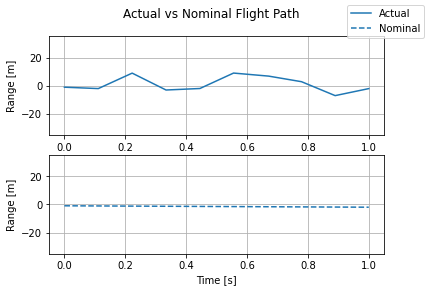

In [27]:
# interpolate platform mortion from the given points
t_temp = np.linspace(0, n_seconds, num=10)
f_y = interpolate.interp1d(t_temp, waypoints[0], kind='linear')
t_linear = np.linspace(0, n_seconds, int(n_pulses), endpoint=True)
real_motion = f_y(t_linear)

# interpolate start and end points to form nominal flight path
linear_fit = np.polyfit(np.array([0, n_seconds]), np.array([real_motion[0], real_motion[-1]]), deg=1)
n_range = np.poly1d(linear_fit) # the nominal path the plane should have
nominal_motion = n_range(t_linear)
# nominal_motion = np.transpose(nominal_motion)

range_dev = np.subtract(nominal_motion, 0.5*real_motion)

fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(t_linear, real_motion, '-', label='Actual')
ax1.set(ylabel='Range [m]', ylim=[-35,35])
ax1.grid()

ax2.plot(t_linear, nominal_motion, '--', label='Nominal')
ax2.set(xlabel='Time [s]', ylabel='Range [m]', ylim=[-35,35])
fig.suptitle('Actual vs Nominal Flight Path')
fig.legend()
ax2.grid()

Apply corrected range to raw data

In [28]:
delta_phase = np.multiply(-1j*(4*np.pi)/wavelength, range_dev)

phase_dev = np.exp(delta_phase) # phase deviation of signal
phase_dev = np.dstack((phase_dev,))

bb_mocomp = np.multiply(bb_matrix, phase_dev)

Generate a phase plot of the motion corrected data

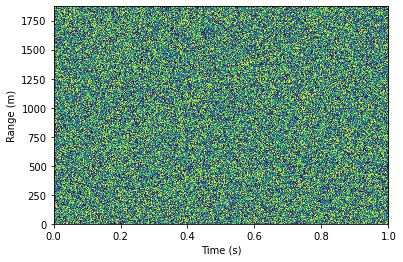

In [29]:
image_axes = [0, n_seconds, r_fft[-1], r_fft[0]]

image_data = np.angle(bb_mocomp[:,:,0])

fig, ax = plt.subplots(nrows=1, ncols=1)
im = ax.imshow(
    image_data,
    aspect='auto',
    interpolation='none',
    extent=image_axes,
)
ax.set_ylim(0, r_fft[-1])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Range (m)')
title = 'rtp_phase_shift_' + str(height) + 'm.png'
fig.savefig(title, dpi=300)

Apply range-bin shifting to data

In [30]:
# find max r_fft
# determine range bin size = r_fft/ns_fft
rbin_size = int(r_fft[-1])/ns_fft # [m] of each range bin

# how many range bins is delta_r?
delta_rbins = np.floor(range_dev/rbin_size)

# new_rbin = rbin + np.ceil(delta_rbin)
temp = np.zeros((ns_fft, n_pulses, bb_mocomp.shape[2])).astype('complex64')
# temp = np.dstack((temp,))

for i in range(0, n_pulses):
    for j in range(0, ns_fft):
        new_rbin = j + int(delta_rbins[i])
        
        # shift range bin from j to new_rbin
        if (new_rbin >= 0 and new_rbin < ns_fft):
            temp[j,i] = bb_mocomp[new_rbin, i]

bb_mocomp = temp

Generate a range-time-intensity plot of the range corrected data

/tmp/ipykernel_43949/2029907098.py:5: RuntimeWarning: divide by zero encountered in log10
  return 10*np.log10(lin)


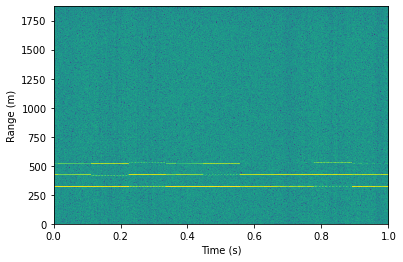

In [31]:
image_axes = [0, n_seconds, r_fft[-1], r_fft[0]]

image_data = lin2db(abs(bb_mocomp[:,:,0]))
dmax = np.amax(image_data)
dmin = np.nanmin(np.mean(image_data, axis=1))
image_data = np.clip(image_data, dmin, dmax)

fig, ax = plt.subplots(nrows=1, ncols=1)
im = ax.imshow(
    image_data,
    aspect='auto',
    interpolation='none',
    extent=image_axes,
)
ax.set_ylim(0, r_fft[-1])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Range (m)')
title = 'rti_range_shift_' + str(height) + 'm.png'
fig.savefig(title, dpi=300)

Plot signal phase after proposed motion compensation

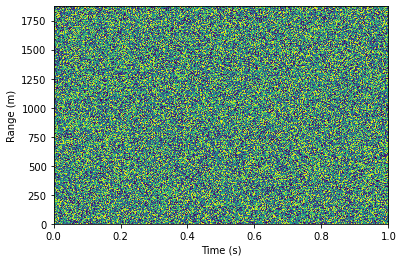

In [32]:
image_axes = [0, n_seconds, r_fft[-1], r_fft[0]]

image_data = np.angle(bb_mocomp[:,:,0])

fig, ax = plt.subplots(nrows=1, ncols=1)
im = ax.imshow(
    image_data,
    aspect='auto',
    interpolation='none',
    extent=image_axes,
)
ax.set_ylim(0, r_fft[-1])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Range (m)')
title = 'rtp_range_shift_' + str(height) + 'm.png'
fig.savefig(title, dpi=300)